In [1]:
import math
import random
import time

import sklearn.metrics
from numpy import arange, c_
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score

import scipy
from scipy import optimize

import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

sns.reset_orig()


noise = 16
samples = 2425
seed = 244825
classes = 2
train_split = 100
test_split = 0.2
repeats = 100

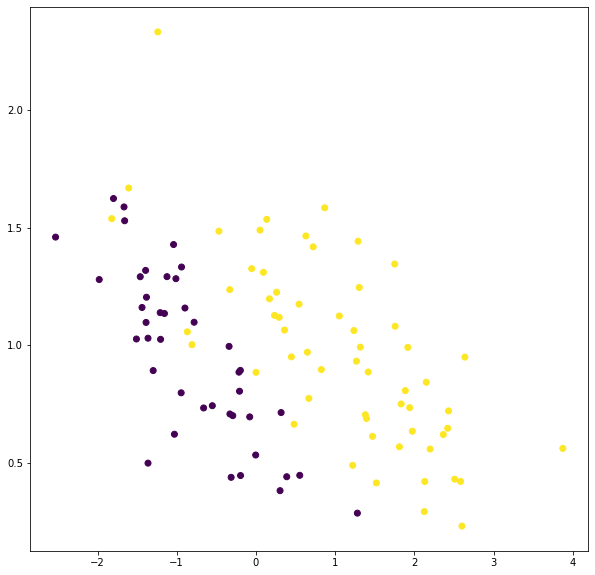

In [2]:
X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)

y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, test_size=test_split, random_state=seed)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                       np.arange(X.min(), X.max(), 0.01))

plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

# moja implementacja

In [3]:
from scipy.optimize import LinearConstraint, Bounds, minimize


def linear_kernel(x1, x2, *args):
    return np.dot(x1, x2)


def poly_kernel(x1, x2, *args): # args[0] - degree, args[1] - gamma, args[2] - intercept
    return (args[1] * x1 @ x2.T + args[2]) ** args[0]
    # return (1 + x1 @ x2) ** args[0]


def rbf_kernel(x1, x2, *args):  # args[0] - degree, args[1] - gamma, args[2] - intercept
    return np.exp(-args[1] * np.linalg.norm(x1 - x2) ** 2)


def decision_function(x, w, b, linear, support_param=None, alpha_param=None, train_labels2=None, train_vector=None, kernel=None, degree=None, gamma=None):
    if linear:
        return np.dot(x, w) + b
    else:
        y_pred = []
        for sample in x:
            pred = 0
            for i in support_param:
                pred += alpha_param[i] * train_labels2[i] * kernel(sample, train_vector[i, :], degree, gamma, b)
            y_pred.append(pred)

        return np.array(y_pred)


def lagrange_function(alpha2, x, y2, kernel, degree, gamma):
    res = 0
    for i in range(alpha2.shape[0]):
        for j in range(alpha2.shape[0]):
            res += alpha2[i] * alpha2[j] * y2[i] * y2[j] * kernel(x[i], x[j], degree, gamma, 0)

    return  0.5 * res - sum(alpha2)


def fit(x_train, y_train2, kernel, degree=1, gamma=0.1, C=1.0):
    ZERO = 1e-5

    n, m = x_train.shape
    # np.random.seed(self.random_state)
    alpha_start = np.random.uniform(0, C, size=n)
    # alpha_start = np.zeros(n)
    linear_constraint = LinearConstraint(A=y_train2, lb=[0], ub=[0])
    bounds = Bounds(np.zeros(n), np.full(n, C-ZERO))
    result = minimize(
        fun=lagrange_function,
        x0=alpha_start,
        args=(x_train, y_train2, kernel, degree, gamma),
        # hess=BFGS(),
        constraints=[linear_constraint],
        bounds=bounds)
    alpha_ = result.x
    alpha_[alpha_ < ZERO] = 0
    support_ = np.where(alpha_ > ZERO)[0]
    support_vectors_ = x_train[support_]
    support_labels = y_train2[support_]
    train_vectors_ = x_train
    train_labels = y_train2

    coef_ = np.zeros(m)
    for i in support_:
        coef_ += alpha_[i] * y_train2[i] * x_train[i]

    intercept_ = 0
    # c_num = self.C - ZERO
    for i in support_:
        intercept_ += y_train2[i] - np.dot(coef_, x_train[i])
    intercept_ /= len(support_)
    print(coef_, intercept_)
    return coef_, intercept_, support_vectors_, support_, alpha_, train_labels, train_vectors_



def predict(x, w, b, linear, support_param=None, alpha_param=None, train_labels=None, train_vector=None, kernel=None, degree=None, gamma=None):
    return np.sign(decision_function(x, w, b, linear, support_param, alpha_param, train_labels, train_vector, kernel, degree, gamma))

### linear

In [4]:
linear_time = time.perf_counter()
theta, bias, support_v, support, alpha, train_label, train_vectors = fit(X_train, y_train, kernel=linear_kernel, degree=1, gamma=0.1, C=1.0)
linear_time = time.perf_counter() - linear_time
print(linear_time)

C:\Users\Jakub\anaconda3\envs\PUM\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


[1.74608538 2.73722843] -2.374314274320255
63.887107799997466


In [5]:
predict_var = predict(X_test, theta, bias, linear=True)

Czulosc: 0.963265306122449
Swoistosc: 0.9416666666666667
Accuracy: 0.9525773195876288
ROC auc: 0.9528510638297873
F1 score: 0.9535353535353536
BA score: 0.9528510638297871


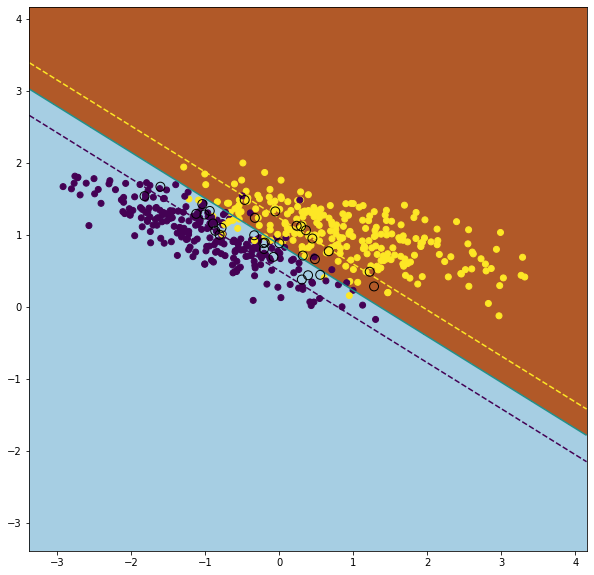

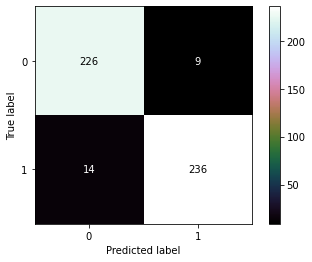

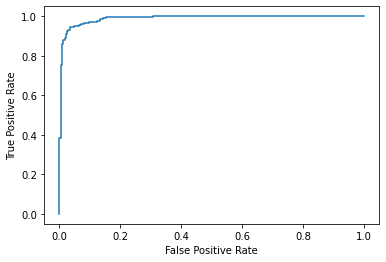

In [6]:
mesh_data = c_[xx.ravel(), yy.ravel()]


predict_cntr = predict(mesh_data, theta, bias, True)
predict_cntr = predict_cntr.reshape(xx.shape)

Z = decision_function(mesh_data, theta, bias, True).reshape(xx.shape)

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, Z > 0, cmap=plt.cm.Paired)
plt.contour(xx, yy, Z, linestyles=["--", "-", "--"], levels=[-1, 0, 1])
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.scatter(support_v[:, 0], support_v[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')

cm_model = confusion_matrix(y_test, predict_var, labels=[-1, 1])
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, decision_function(X_test, theta, bias, True))

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()


print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, predict_var))
print("F1 score:", f1_score(y_test, predict_var))
print("BA score:", balanced_accuracy_score(y_test, predict_var))

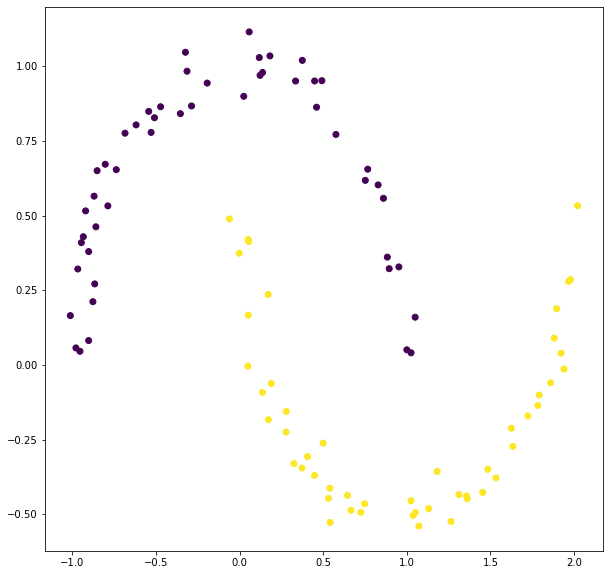

In [7]:
# X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)
X, y = datasets.make_moons(random_state=seed, n_samples=samples, noise=0.05)

y[y == 0] = -1

poly = PolynomialFeatures(degree=4, include_bias=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, test_size=test_split, random_state=seed, shuffle=True, stratify=y)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                       np.arange(X.min(), X.max(), 0.01))

# X_train = my_normalize(X_train)
# X_test = my_normalize(X_test)
# X_train = poly.fit_transform(X_train)
# X_test = poly.fit_transform(X_test)


plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

### poly

In [8]:
poly_time = time.perf_counter()
theta, bias, support_v, support, alpha, train_labels, train_vectors = fit(X_train, y_train, degree=3, kernel=poly_kernel, gamma=0.75, C=1.0)
poly_time = time.perf_counter() - poly_time
print(poly_time)

[ 1.65414572 -8.08402419] 1.1962720466978995
61.34417200000098


Czulosc: 1.0
Swoistosc: 0.6269430051813472
Accuracy: 0.7030927835051546
ROC auc: 0.7037037037037037
F1 score: 0.5789473684210525
BA score: 0.7037037037037037


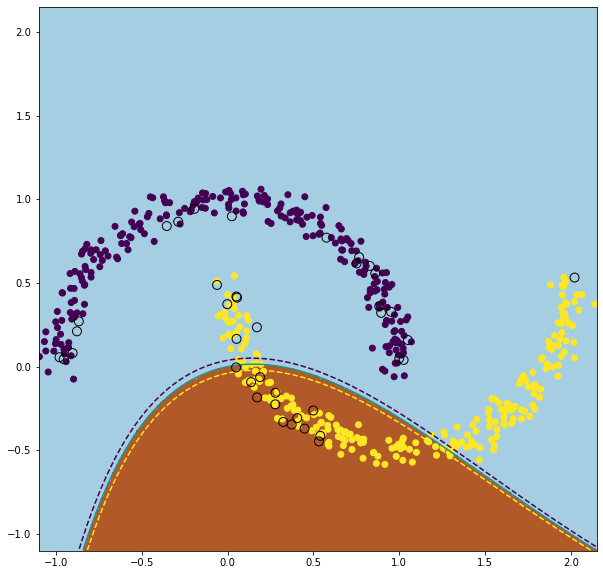

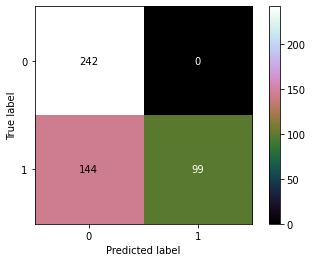

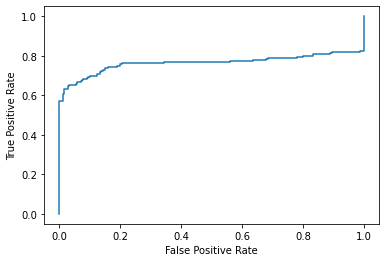

In [9]:
predict_var = predict(X_test, theta, bias, False, support, alpha, train_labels, train_vectors, poly_kernel, 3, 0.75)
mesh_data = c_[xx.ravel(), yy.ravel()]

# mesh_data = poly.fit_transform(mesh_data)


predict_cntr = predict(mesh_data, theta, bias, False, support, alpha, train_labels, train_vectors, poly_kernel, 3, 0.75)
predict_cntr = predict_cntr.reshape(xx.shape)

Z = decision_function(mesh_data, theta, bias, False, support, alpha, train_labels, train_vectors, poly_kernel, 3, 0.75).reshape(xx.shape)

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, Z > 0, cmap=plt.cm.Paired)
plt.contour(xx, yy, Z, linestyles=["--", "-", "--"], levels=[-1, 0, 1])
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.scatter(support_v[:, 0], support_v[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')

cm_model = confusion_matrix(y_test, predict_var, labels=[-1, 1])
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, decision_function(X_test, theta, bias, False, support, alpha, train_labels, train_vectors, poly_kernel, 3, 0.75))

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()

print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, predict_var))
print("F1 score:", f1_score(y_test, predict_var))
print("BA score:", balanced_accuracy_score(y_test, predict_var))

### rbf

In [10]:
rbf_time = time.perf_counter()
theta, bias, support_v, support, alpha, train_labels, train_vectors = fit(X_train, y_train, kernel=rbf_kernel, gamma=0.75, C=1.0)
rbf_time = time.perf_counter() - rbf_time
print(rbf_time)

[ 5.07116816 -2.9866726 ] -1.6316409636976092
255.57682130000103


Czulosc: 0.9836734693877551
Swoistosc: 0.9916666666666667
Accuracy: 0.9876288659793815
ROC auc: 0.9876203108526341
F1 score: 0.9877049180327868
BA score: 0.9876203108526341


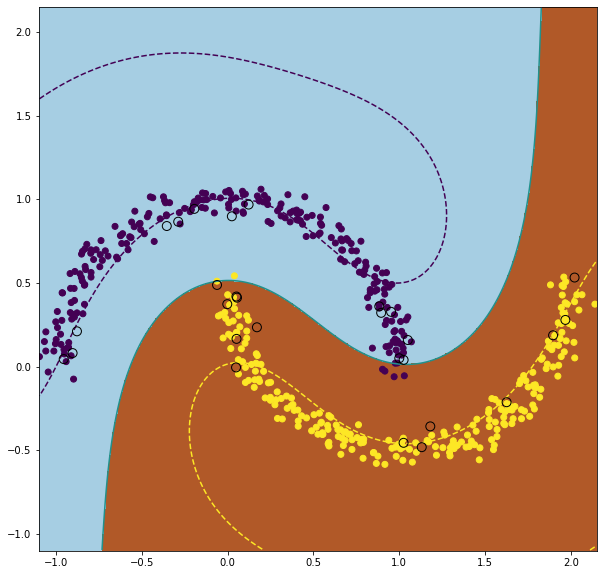

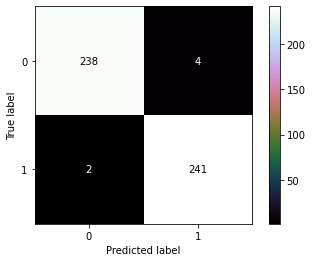

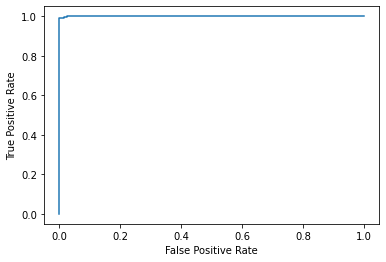

In [11]:
predict_var = predict(X_test, theta, bias, False, support, alpha, train_labels, train_vectors, rbf_kernel, 1, 0.75)
mesh_data = c_[xx.ravel(), yy.ravel()]

# mesh_data = poly.fit_transform(mesh_data)


predict_cntr = predict(mesh_data, theta, bias, False, support, alpha, train_labels, train_vectors, rbf_kernel, 1, 0.75)
predict_cntr = predict_cntr.reshape(xx.shape)

Z = decision_function(mesh_data, theta, bias, False, support, alpha, train_labels, train_vectors, rbf_kernel, 1, 0.75).reshape(xx.shape)

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, Z > 0, cmap=plt.cm.Paired)
plt.contour(xx, yy, Z, linestyles=["--", "-", "--"], levels=[-1, 0, 1])
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.scatter(support_v[:, 0], support_v[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')

cm_model = confusion_matrix(y_test, predict_var, labels=[-1, 1])
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, decision_function(X_test, theta, bias, False, support, alpha, train_labels, train_vectors, rbf_kernel, 1, 0.75))

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()

print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, predict_var))
print("F1 score:", f1_score(y_test, predict_var))
print("BA score:", balanced_accuracy_score(y_test, predict_var))

# SKLEARN

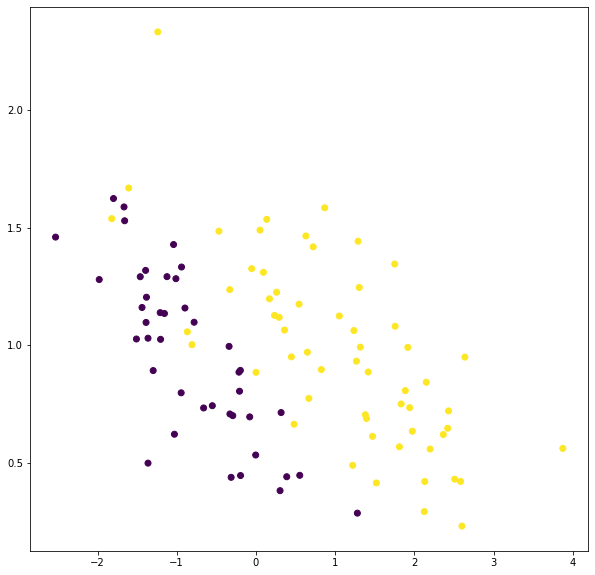

In [12]:
X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)

y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, test_size=test_split, random_state=seed)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                       np.arange(X.min(), X.max(), 0.01))

plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

### Linear

0.0016828000007080846
Czulosc: 0.9705882352941176
Swoistosc: 0.9230769230769231
Accuracy: 0.9463917525773196
ROC auc: 0.9471063829787233
F1 score: 0.9467213114754099
BA score: 0.9471063829787234


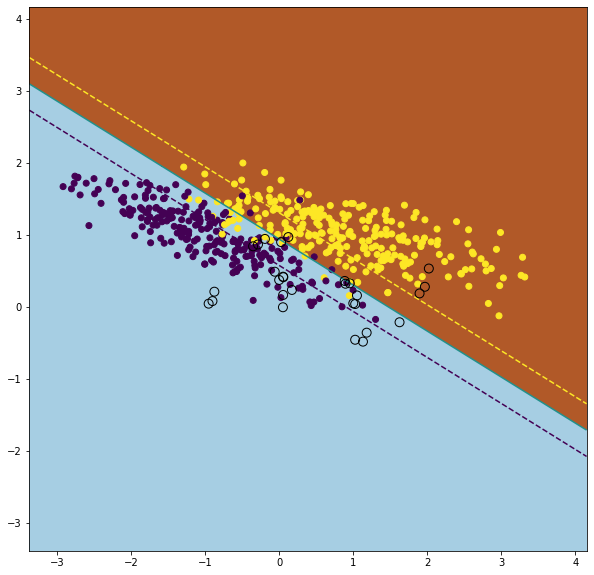

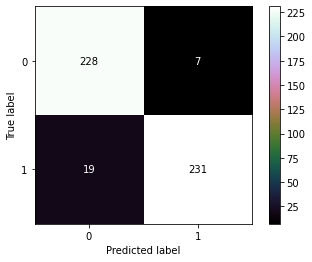

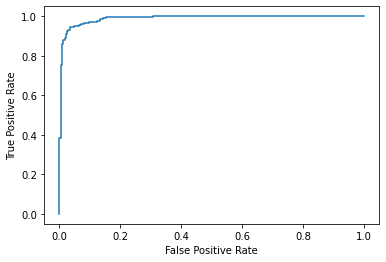

In [13]:
model = SVC(kernel='linear', gamma=0.1, degree=1, random_state=seed, C=1)

sklinear_time = time.perf_counter()
model.fit(X_train, y_train)
sklinear_time = time.perf_counter() - sklinear_time
print(sklinear_time)

prd = model.predict(X_test)

mesh_data = c_[xx.ravel(), yy.ravel()]

predict_cntr = model.predict(mesh_data)
predict_cntr = predict_cntr.reshape(xx.shape)

Z = model.decision_function(mesh_data).reshape(xx.shape)

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, Z > 0, cmap=plt.cm.Paired)
plt.contour(xx, yy, Z, linestyles=["--", "-", "--"], levels=[-1, 0, 1])
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.scatter(support_v[:, 0], support_v[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')

cm_model = confusion_matrix(y_test, prd, labels=[-1, 1])
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, model.decision_function(X_test))

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()

print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, prd))
print("F1 score:", f1_score(y_test, prd))
print("BA score:", balanced_accuracy_score(y_test, prd))

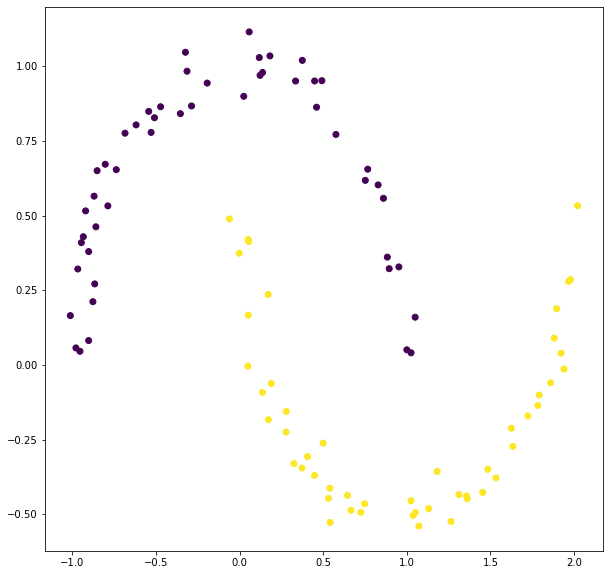

In [14]:
# X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)
X, y = datasets.make_moons(random_state=seed, n_samples=samples, noise=0.05)

y[y == 0] = -1

poly = PolynomialFeatures(degree=4, include_bias=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, test_size=test_split, random_state=seed, shuffle=True, stratify=y)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                       np.arange(X.min(), X.max(), 0.01))

# X_train = my_normalize(X_train)
# X_test = my_normalize(X_test)
# X_train = poly.fit_transform(X_train)
# X_test = poly.fit_transform(X_test)


plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

### Poly

0.0016131000011228025
Czulosc: 0.8617021276595744
Swoistosc: 1.0
Accuracy: 0.9195876288659793
ROC auc: 0.9194214876033058
F1 score: 0.9257142857142857
BA score: 0.9194214876033058


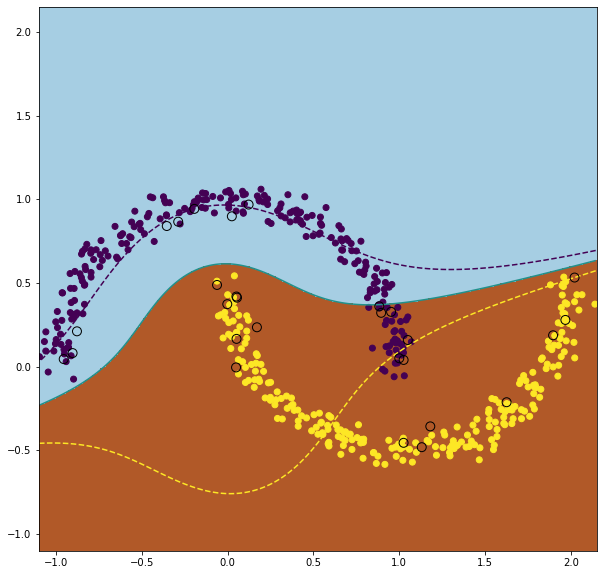

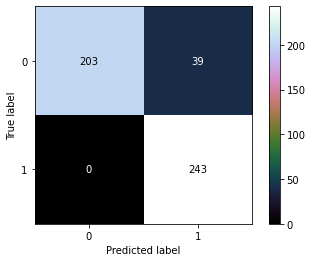

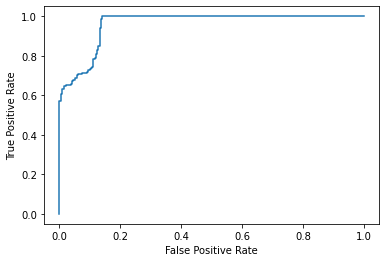

In [15]:
model = SVC(kernel='poly', gamma=0.75, degree=3, random_state=seed, C=1)

skpoly_time = time.perf_counter()
model.fit(X_train, y_train)
skpoly_time = time.perf_counter() - skpoly_time
print(skpoly_time)

prd = model.predict(X_test)

mesh_data = c_[xx.ravel(), yy.ravel()]

predict_cntr = model.predict(mesh_data)
predict_cntr = predict_cntr.reshape(xx.shape)

Z = model.decision_function(mesh_data).reshape(xx.shape)

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, Z > 0, cmap=plt.cm.Paired)
plt.contour(xx, yy, Z, linestyles=["--", "-", "--"], levels=[-1, 0, 1])
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.scatter(support_v[:, 0], support_v[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')

cm_model = confusion_matrix(y_test, prd, labels=[-1, 1])
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, model.decision_function(X_test))

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()

print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, prd))
print("F1 score:", f1_score(y_test, prd))
print("BA score:", balanced_accuracy_score(y_test, prd))

0.000994000001810491
Czulosc: 0.9836734693877551
Swoistosc: 0.9916666666666667
Accuracy: 0.9876288659793815
ROC auc: 0.9876203108526341
F1 score: 0.9877049180327868
BA score: 0.9876203108526341


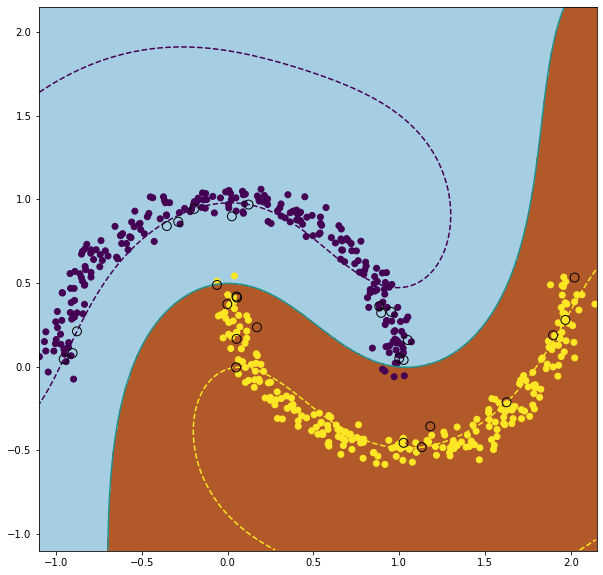

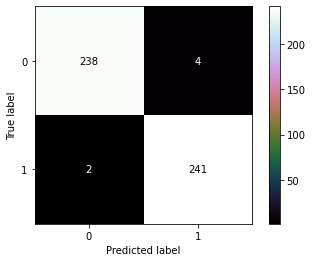

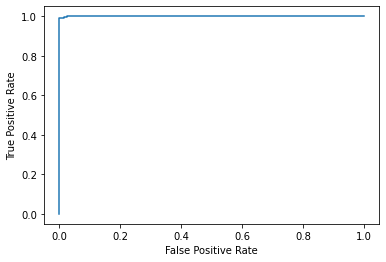

In [16]:
model = SVC(kernel='rbf', gamma=0.75, degree=3, random_state=seed, C=1)

skrbf_time = time.perf_counter()
model.fit(X_train, y_train)
skrbf_time = time.perf_counter() - skrbf_time
print(skrbf_time)

prd = model.predict(X_test)

mesh_data = c_[xx.ravel(), yy.ravel()]

predict_cntr = model.predict(mesh_data)
predict_cntr = predict_cntr.reshape(xx.shape)

Z = model.decision_function(mesh_data).reshape(xx.shape)

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, Z > 0, cmap=plt.cm.Paired)
plt.contour(xx, yy, Z, linestyles=["--", "-", "--"], levels=[-1, 0, 1])
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.scatter(support_v[:, 0], support_v[:, 1], s=80, facecolors='none', zorder=10, edgecolors='k')

cm_model = confusion_matrix(y_test, prd, labels=[-1, 1])
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, model.decision_function(X_test))

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()

print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, prd))
print("F1 score:", f1_score(y_test, prd))
print("BA score:", balanced_accuracy_score(y_test, prd))

# Cz 3

In [17]:
data = pd.read_csv('star_classification_SDSS17.csv')
data

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


In [18]:
data = data.dropna(axis=0, subset=['class'])
data = data[data['class'] != 'QSO']
data.loc[ data['class'] == 'GALAXY', 'class'] = -1
data.loc[ data['class'] == 'STAR', 'class'] = 1
data['class'] = data['class'].apply(lambda x: int(x))

In [19]:
cols_to_drop = list(filter(lambda x: 'ID' in x, data.columns))

cols_to_drop.append('plate')
cols_to_drop.append('MJD')
cols_to_drop.append('cam_col')

data = data.drop(axis=1, columns=cols_to_drop)

In [20]:
data

,alpha,delta,u,g,r,i,z,class,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,-1,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,-1,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,-1,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,-1,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,-1,0.116123
...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,-1,0.000000
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,-1,0.404895
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,-1,0.143366
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,-1,0.455040


In [21]:
# for col in data.columns:
#     data[col] = pd.to_numeric(data[col], errors='coerce')
# data

In [22]:
medians = data.median(axis=0, numeric_only=True)

for index, value in medians.items():
    data[index].fillna(value, inplace=True)

data1 = data
data

,alpha,delta,u,g,r,i,z,class,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,-1,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,-1,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,-1,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,-1,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,-1,0.116123
...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,-1,0.000000
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,-1,0.404895
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,-1,0.143366
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,-1,0.455040


In [23]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        if df[feature_name].dtype == 'float64' or df[feature_name].dtype == 'int32':
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result


def winsorize(df):
    for i in df.columns:
        q1 = df[i].quantile(0.25)
        q3 = df[i].quantile(0.75)

        iqr = q3 - q1

        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)

        df.loc[df[i] < lower_bound, i] = lower_bound
        df.loc[df[i] > upper_bound, i] = upper_bound
    return df


data = winsorize(data)
data = normalize(data)

data

,alpha,delta,u,g,r,i,z,class,redshift
0,0.376905,0.503802,0.619894,0.625757,0.586097,0.549339,0.551568,-1,0.472086
1,0.402286,0.491812,0.680308,0.663648,0.759258,0.739232,0.839256,-1,0.577771
2,0.394960,0.534139,0.712942,0.652211,0.603082,0.566679,0.567332,-1,0.478969
3,0.940947,0.180600,0.502799,0.727959,0.682318,0.676303,0.598118,-1,0.689949
4,0.959118,0.392679,0.321333,0.306129,0.277844,0.246953,0.220170,-1,0.092324
...,...,...,...,...,...,...,...,...,...
99995,0.110044,0.159072,0.504867,0.673449,0.705445,0.752258,0.749644,-1,0.007300
99996,0.081913,0.379072,0.540062,0.633312,0.590449,0.605467,0.614964,-1,0.303758
99997,0.623848,0.338810,0.437754,0.421160,0.412834,0.409423,0.404539,-1,0.112270
99998,0.589629,0.642974,0.718811,0.582341,0.548043,0.540502,0.534342,-1,0.340473


In [24]:
data.corr().style.background_gradient(cmap='viridis')

,alpha,delta,u,g,r,i,z,class,redshift
alpha,1.000000,0.143788,0.003089,-0.015655,-0.030279,-0.036464,-0.041088,-0.017150,-0.033395
delta,0.143788,1.000000,-0.007984,-0.007140,-0.024570,-0.032859,-0.040795,-0.000346,-0.021365
u,0.003089,-0.007984,1.000000,0.873181,0.794114,0.721266,0.660315,-0.266728,0.591804
g,-0.015655,-0.007140,0.873181,1.000000,0.951101,0.891056,0.826943,-0.260690,0.698013
r,-0.030279,-0.024570,0.794114,0.951101,1.000000,0.970973,0.929110,-0.147358,0.641116
i,-0.036464,-0.032859,0.721266,0.891056,0.970973,1.000000,0.972572,-0.078728,0.574847
z,-0.041088,-0.040795,0.660315,0.826943,0.929110,0.972572,1.000000,-0.029817,0.517100
class,-0.017150,-0.000346,-0.266728,-0.260690,-0.147358,-0.078728,-0.029817,1.000000,-0.637859
redshift,-0.033395,-0.021365,0.591804,0.698013,0.641116,0.574847,0.517100,-0.637859,1.000000


In [25]:
from sklearn.model_selection import GridSearchCV

X = data.drop(axis=1, columns='class').to_numpy()
y = data['class'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=seed)

In [26]:
model_svc = SVC()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 5, 10]}
clf = GridSearchCV(model_svc, parameters, n_jobs=4)

In [27]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(), n_jobs=4,
             param_grid={'C': [1, 5, 10], 'kernel': ('linear', 'rbf')})

In [28]:
print(clf.best_params_)

{'C': 10, 'kernel': 'rbf'}


In [29]:
y_predicted = clf.predict(X_test)

Czulosc: 0.9705286839145106
Swoistosc: 0.9998299753464253
Accuracy: 0.991794175715696
ROC auc: 0.9942603995115757
F1 score: 0.9848190845793858
BA score: 0.9942603995115757


<Figure size 720x720 with 0 Axes>

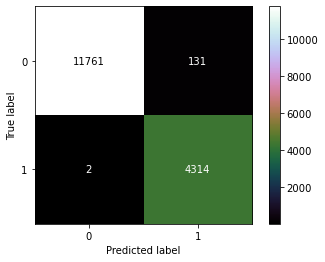

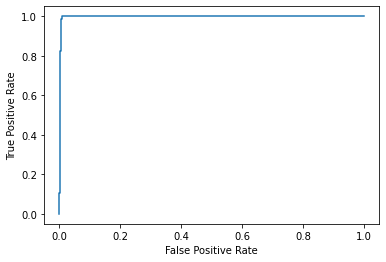

In [30]:
plt.figure(figsize=(10, 10))

cm_model = confusion_matrix(y_test, y_predicted, labels=[-1,1])
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, clf.decision_function(X_test))

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()

print("Czulosc:", tp_model/(tp_model + fn_model))
print("Swoistosc:", tn_model/(tn_model + fp_model))
print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("ROC auc:", roc_auc_score(y_test, y_predicted))
print("F1 score:", f1_score(y_test, y_predicted))
print("BA score:", balanced_accuracy_score(y_test, y_predicted))